In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# plt.style.use(["science"])
import corner

from synthpop.models import AxtellModel
from synthpop.optimise import Optimise, TBS_SMC
from synthpop.generative import SampleGenerator
import pygtc

# 1 . Define model and loss function

In [13]:
model = AxtellModel(N=1000, v=1)

def loss(x):
    ts, ass, _, efforts = x
    init_mean_efforts = efforts[0].mean()
    previous_efforts = efforts[0].copy()
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        previous_efforts = model.reconstruct_effort(previous_efforts, agent, efforts[i+1])
    return (previous_efforts.mean() - init_mean_efforts) + 1

class MetaGenerator(SampleGenerator):
    def forward(self, generator_params):
        E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = generator_params
        def generator(n_agents):
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents)
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator

# 2. TBS-SMC

In [15]:
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                                    torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])), reinterpreted_batch_ndims=1)
meta_generator = MetaGenerator()
optimise = Optimise(model=model, meta_generator=meta_generator, prior=prior, loss=loss)
optimise_method = TBS_SMC(num_particles = 10_000, num_initial_pop=20_000, num_simulations=50_000, epsilon_decay=0.8)
trained_meta_generator = optimise.fit(optimise_method, num_workers=-1)

Running 20000 simulations in 20000 batches.:   0%|          | 0/20000 [00:00<?, ?it/s]

/Users/joeyer/Documents/Code/synthpop/synthpop/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 8857 simulations in 8857 batches.:   0%|          | 0/8857 [00:00<?, ?it/s]

Running 7913 simulations in 7913 batches.:   0%|          | 0/7913 [00:00<?, ?it/s]

Running 3230 simulations in 3230 batches.:   0%|          | 0/3230 [00:00<?, ?it/s]

In [16]:
# get predicted efforts.
def get_mean_efforts(ts, ass, a_efforts):
    mean_efforts = [a_efforts[0].mean()]
    last_efforts = a_efforts[0]
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        new_efforts = model.reconstruct_effort(last_efforts, agent, a_efforts[i+1])
        mean_efforts.append(new_efforts.mean())
        last_efforts = new_efforts
    return mean_efforts

def get_pred_efforts_from_generator(meta_generator, n = 25):
    pred_efforts = []
    times = []
    for j in range(n):
        generator = meta_generator()
        ts, ass, _, a_efforts = model(generator)
        mean_efforts= get_mean_efforts(ts, ass, a_efforts)
        pred_efforts.append(mean_efforts)
        times.append(ts)
    return times, pred_efforts

prior_times, prior_pred_efforts = get_pred_efforts_from_generator(lambda: meta_generator(prior.sample()))
post_times, post_pred_efforts = get_pred_efforts_from_generator(trained_meta_generator)

Text(0.5, 0, 'Time')

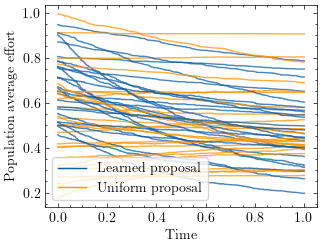

In [17]:
fig, ax = plt.subplots(1,1)
alpha = 0.75
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=alpha, c="C0")
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=alpha, c="C2")
ax.plot([], [], color = "C0", label="Learned proposal")
ax.plot([], [], color = "C2", label="Uniform proposal")
plt.legend(facecolor='white', framealpha=0.8, frameon=True, loc="lower left")
ax.set_ylabel("Population average effort")
ax.set_xlabel("Time")
# fig.savefig("../figures/paper/axtell_effort_smcabc.pdf", bbox_inches="tight")

# 3. Variational Optimisation with a Normalising Flow

In [38]:
from synthpop.generative import MaskedAutoRegressiveFlow
from synthpop.optimise import VO

dom_min = torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) + 1e-8 # tolerance
dom_max = torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5]) - 1e-8
class FlowMetaGenerator(MaskedAutoRegressiveFlow):
    dom_min = dom_min # Change this and below to just dom_ rather than prior_?
    dom_max = dom_max
    def forward(self, generator_params=None):
        if generator_params is None:
            generator_params = self.sample(1)[0][0]
        # constrain parameters to domain
        params = torch.sigmoid(generator_params)
        params = self.dom_min + (self.dom_max - self.dom_min) * params
        def generator(n_agents):
            E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = params
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents) 
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator
flow_meta_generator = FlowMetaGenerator(min_values = dom_min, 
                                        max_values = dom_max, 
                                        n_parameters = 9, 
                                        n_hidden_units = 32, 
                                        n_transforms = 4)

In [39]:
# make aux prior so that regularisation loss is the entropy.
inff = 1000

# Sometimes control variates are helpful for helping to converge during training 
b = 1.
def cv_loss(x):
    return loss(x) - b

# Set the domain (or, more generally, the prior)
dom_vo = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(9), inff * torch.ones(9)), 1)
optimise = Optimise(model=model, meta_generator=flow_meta_generator, prior=dom_vo, loss=cv_loss)
optimizer = torch.optim.AdamW(flow_meta_generator.parameters(), lr=5e-4)
optimise_method = VO(w=0.01, n_samples_per_epoch=50, optimizer=optimizer, 
                    progress_bar=True, 
                    progress_info=True, 
                    gradient_estimation_method="score", 
                    log_tensorboard=True, 
                    gradient_clipping_norm=10.0,
                    )
optimise.fit(optimise_method, n_epochs=1000, max_epochs_without_improvement=np.inf);

 18%|███████████████████████████▍                                                                                                                                | 176/1000 [05:44<26:51,  1.96s/it, loss=-.204, reg.=0.69, total=0.486, best loss=-.21, epochs since improv.=2]


KeyboardInterrupt: 

In [40]:
# load best model
flow_meta_generator.load_state_dict(torch.load("./best_estimator.pt"))

<All keys matched successfully>

In [41]:
with torch.no_grad():
    flow_post_times, flow_post_pred_efforts = get_pred_efforts_from_generator(flow_meta_generator)

Text(0.5, 0, 'Time')

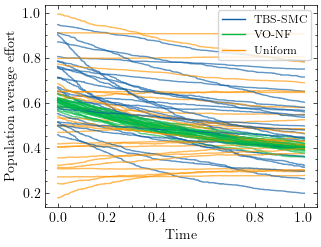

In [42]:
fig, ax = plt.subplots(1,1)
alpha = 0.65
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=alpha, c="C0")
    ax.plot(flow_post_times[i], flow_post_pred_efforts[i], alpha=alpha, c="C1")
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=alpha, c="C2")
ax.plot([], [], color = "C0", label="TBS-SMC")
ax.plot([], [], color = "C1", label="VO-NF")
ax.plot([], [], color = "C2", label="Uniform")
ax.legend(facecolor='white', framealpha=0.8, frameon=True, fontsize=8)
ax.set_ylabel("Population average effort")
ax.set_xlabel("Time")
# fig.savefig("../figures/paper/axtell_effort.pdf", bbox_inches="tight")

In [43]:
# plot flow
with torch.no_grad():
    samples = flow_meta_generator.sample(10000)[0]
    #samples = torch.sigmoid(samples)
    #samples = flow_meta_generator.prior_min + samples * (flow_meta_generator.prior_max - flow_meta_generator.prior_min)

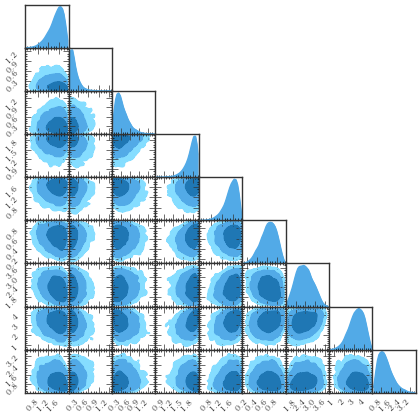

In [44]:

pygtc.plotGTC([samples.numpy()], 
              figureSize="MNRAS_page",
              nContourLevels=3, 
              );